In [1]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import time
import matplotlib.pyplot as plt
import random

In [2]:
from src.data.make_dataset import make_dataset
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.data.image_loaders import AerialCarsImageLoader
from src.features.pipelines import RawImageToFeatures
from src.features.processors import RotateToHorizontal, Resize
from src.features.descriptors import HOGDescriptor, LBPDescriptor
from src.models.detectors import SliderDetector
from src.data.sliders import SlidingWindow

## Features dataset

In [3]:
start_time = time.time()

data = make_dataset(
    input_folder_filepath='../../data/interim/aerial-cars-dataset/',
    output_filepath='output_path',
    dataset_loader=AerialCarsDatasetLoader(
        image_loader=AerialCarsImageLoader()
    ),
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    process_pipeline=RawImageToFeatures(
        processors=[
            RotateToHorizontal(),
            Resize(
                output_size=(64, 64)
            )
        ],
        descriptors=[
            HOGDescriptor(
                orientations = 9,
                cells_per_block = (2, 2),
                pixels_per_cell = (4, 4),
                multichannel = True,
                visualize = True
            ),
            LBPDescriptor(
                bins = 256,
                range = (0, 256)
            )
        ]
    ),
    negative_images_size=(64, 64),
    negative_examples_size=0.5,
    workers=7,
    verbose=True
)

print()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 314/314 [00:00<00:00, 10708.98it/s]

--- 20.946017265319824 seconds ---


## SVM training

In [4]:
X = list(map(lambda x: x[1], data))
y = list(map(lambda x: x[2], data))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# clf = make_pipeline(SVC(gamma='auto'))
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        96
           1       1.00      0.98      0.99       112

    accuracy                           0.99       208
   macro avg       0.99      0.99      0.99       208
weighted avg       0.99      0.99      0.99       208



## Test images loading

In [5]:
dataset_loader=AerialCarsDatasetLoader(
    image_loader=AerialCarsImageLoader()
)
images = dataset_loader.load_dataset(
    input_folder_filepath='../../data/interim/aerial-cars-dataset/val/',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    verbose=True
)

100%|██████████| 8/8 [00:00<00:00, 16.69it/s]


In [6]:
len(images)

4

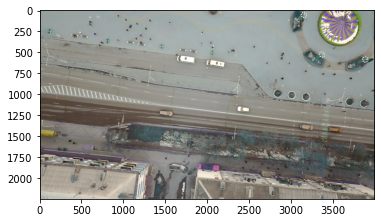

In [7]:
plt.imshow(images[0].image)

## Sliding detection

In [8]:
slider_detector = SliderDetector(
    sliding_window=SlidingWindow(
        step_size=32,
        window_size=(64, 64)
    ),
    process_pipeline=RawImageToFeatures(
        processors=[
            RotateToHorizontal(),
            Resize(
                output_size=(64, 64)
            )
        ],
        descriptors=[
            HOGDescriptor(
                orientations = 9,
                cells_per_block = (2, 2),
                pixels_per_cell = (4, 4),
                multichannel = True,
                visualize = True
            ),
            LBPDescriptor(
                bins = 256,
                range = (0, 256)
            )
        ]
    ),
    classifier=clf
)

### Synchronous approach

In [9]:
start_time = time.time()

(image, bnd_boxes) = slider_detector(images[0], 0, True)

print()
print("--- %s seconds ---" % (time.time() - start_time))

8875it [11:02, 13.39it/s]
--- 662.757426738739 seconds ---



In [10]:
len(bnd_boxes)

3946

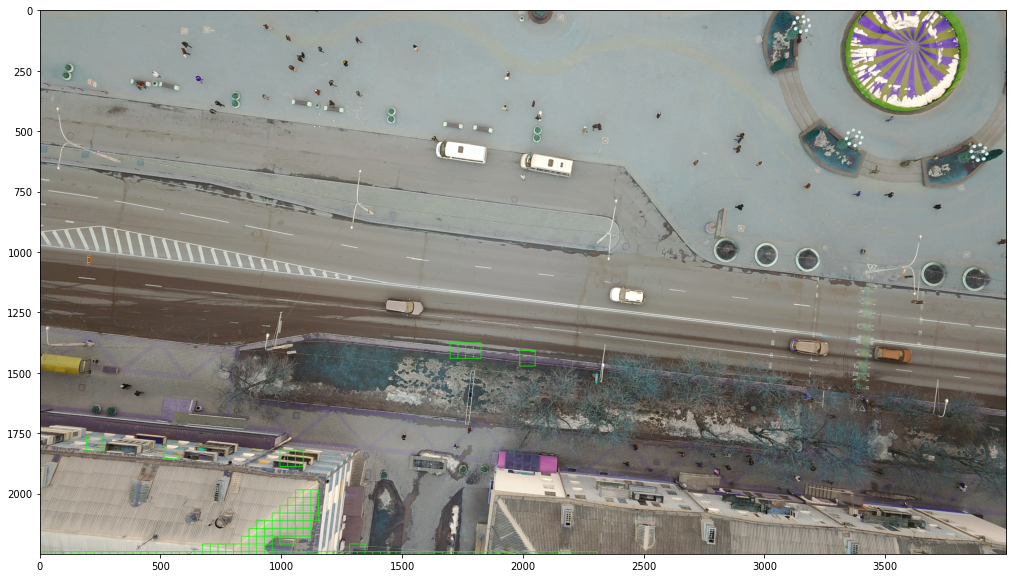

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(image)

### Parallel approach

In [12]:
start_time = time.time()

(image, bnd_boxes) = slider_detector(images[0], 7, True)

print()
print("--- %s seconds ---" % (time.time() - start_time))


--- 279.91735577583313 seconds ---


In [13]:
len(bnd_boxes)

3920

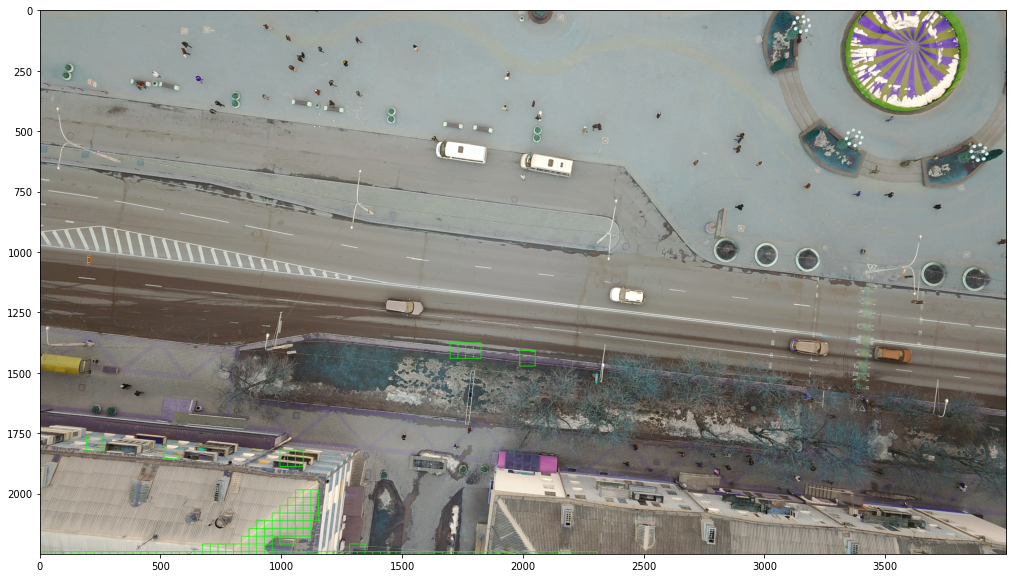

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(image)